<a href="https://colab.research.google.com/github/SAULIZA/nacimientos_defuncion/blob/main/Proyecto_def_nac_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desarrollo del modelo del proyecto
**Proyecto 2 - Parte 4 (base)**
* Crado por: Saúl Iza
* Fecha de realización: 23/04/2023
* Fecha de modificación: 23/04/2023

## Garantiza que completes los pasos de preprocesamiento adecuados

In [52]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config
set_config(display='diagram')

In [83]:
#Adquirimos los datos limpios desde la parte de visualización
df = pd.read_csv("/content/drive/MyDrive/Codificación de Dojo/Proyecto2/datos_nac_def_limpio.csv")

### Elección de las características más importantes

In [55]:
df.columns

Index(['sexo', 'sem_gest', 'anio', 'mes', 'p_emb', 'lugar_ocur', 'provincia',
       'canton', 'parroquia', 'asis_por', 'area', 'edad_mad', 'con_pren',
       'hij_viv', 'hij_vivm', 'hij_nacm', 'etnia', 'est_civil', 'sabe_leer',
       'niv_inst', 'prov_res', 'cant_res', 'parr_res', 'area_res', 'Estado',
       'nuev_estad'],
      dtype='object')

* Sex: el sexo del recién nacido o difunto si será tomado en cuenta
* Sem_gest: las semanas de gestación si se toman en cuenta (debido a que esta característica puede tener un peso considerable con respecto al resto aún está a discusión)
* Anio: El año de nacimiento o defunción no se considera una característica importante, sin embargo no lo eliminaremos pero luego si.
* Mes: El mes de nacimiento o defunción tampoco es una característica importante
* P_emb: El producto de embarazo si será tomda en cuenta
* Lugar_ocurr: el lugar de ocurrencia también será una característica importante a tomar en cuenta
* La provincia, cantón y área también se consideraran más no las parroquias (tanto de nacimientos, como de defunciones)
* El estado civil la etnia, y el nivel de instrucción de la madre también serán tomados en cuenta
* El estado también será eliminado ya que consideramos una nueva clase, en la columna nuevo estado se encuentran clasificados 3, uno de nacimiendo otro de nacido muerto y otro de aborto, según las semanas de gestación.
* Los hijos vivos, hijos nacidos vivos que han muerto, y los hijos que han nacido muertos también serán tomados en cuenta 

In [84]:
col_selec = ['sexo','anio', 'p_emb', 'lugar_ocur',#'sem_gest',
       'asis_por', 'area', 'edad_mad', 'con_pren',
       'hij_viv', 'hij_vivm', 'hij_nacm', 'etnia', 'est_civil', 'sabe_leer',
       'niv_inst', 'prov_res', 'area_res',
       'nuev_estad']

In [85]:
#nuevo marco de datos con las columnas seleccionadas
data = df.loc[:,col_selec]

### Ingeniería de características

In [86]:
#haremos una sola columna con numero de hijos totales que nacieron vivos hij_viv + hij_vivm
data['ThijosV'] = data['hij_viv'] + data['hij_vivm'] 
data = data.drop(['hij_viv', 'hij_vivm'], axis=1)

In [87]:
# debido a la inclongruencia entre nivel de instrucción de la madre y si sabe leer o no
# a la columna de sabe leer no la vamos a eliminar
data.groupby("niv_inst")["sabe_leer"].value_counts()

niv_inst                        sabe_leer
Centro_de_alfabetizacion        Si             2291
                                No               83
                                Ignorado         21
Ciclo_post_bachillerato         Si             7783
Educacion Media / Bachillerato  Si           349355
                                No                5
Educacion_basica                Si           369094
                                Ignorado        684
                                No              288
Ninguno                         No             6206
                                Si             3255
                                Ignorado         49
Posgrado                        Si             5182
Primaria                        Si           250081
                                Ignorado        321
                                No               56
Se_ignora                       Si            12931
                                Ignorado       3364
                      

* La variable nivel de instrucción, es una variable de tipo ordinal, por lo tanto vamos a ordenarlo de la siguiente manera:
0. Se ignora y ninguno
1. Primaria y Centro de alfabetizacion
2. Educación básica y Educacion Media / Bachillerato
3. Ciclo_post_bachillerato y Superior no universitario
4. Superior y Superior universitario
5. Posgrado


In [88]:
niv_instruccion = {'Se_ignora': 0, 'Ninguno': 0, 'Primaria': 1, "Centro_de_alfabetizacion":1, "Educacion_basica":2, "Educacion Media / Bachillerato":2,"Secundaria":2, "Ciclo_post_bachillerato":3, "Superior no universitario":3,"Superior":4,"Superior universitario":4,"Posgrado":5}
data["niv_inst"] = data["niv_inst"].replace(niv_instruccion)

* De igual manera el producto de embarazo es una variable de tipo ordinal, por lo tanto vamos a ordenarlo:
0. Simple
1. Doble
2. Triple
3. Cuadruple o más

In [89]:
prod_emb = {'Simple': 0, 'Doble': 1, "Triple":2, "Cuadruple_o_mas":3}
data["p_emb"] = data["p_emb"].replace(prod_emb)

### Train test split

* Este es un problema de predicción anual, por lo tanto vamos a hacer que los datos de entrenamiento sean los datos recolectados desde los años 2012 hasta 2020 y el conjunto de testeo sea del año 2021.

In [90]:
#filtramos los datos desde el 2012 hasta el 2020
df_2012_2020 = data[(data['anio'] >= 2017) & (data['anio'] <= 2020)]
# filtramos los datos del 2021
df_2021 = data[data['anio'] == 2021]

In [91]:
#comprobamos
df_2012_2020["anio"].value_counts()

2018.0    265923
2017.0    263558
2019.0    258668
2020.0    223322
Name: anio, dtype: int64

In [92]:
df_2021["anio"].value_counts()

2021.0    217341
Name: anio, dtype: int64

In [93]:
#test train split
#características
X_train = df_2012_2020.drop(["anio","nuev_estad"], axis = 1)
X_test = df_2021.drop(["anio","nuev_estad"], axis = 1)

y_train = df_2012_2020["nuev_estad"]
y_test = df_2021["nuev_estad"]

 ### Preparación de datos para aplicar modelos

In [94]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config
set_config(display='diagram')

In [67]:
#Instanciamos column selector
num_selector = make_column_selector(dtype_include = "number")
cat_selector = make_column_selector(dtype_include = "object")

In [68]:
#instanciamos scaler para los datos numéricos
scaler = StandardScaler()
#instanciamos codificación one-hot-endoder para datos nominales
ohe_encoder = OneHotEncoder(drop = "first",sparse_output = False, handle_unknown = "ignore")

In [69]:
#creación de tuplas
num_tuple = (scaler, num_selector)
cat_tuple = (ohe_encoder, cat_selector)

In [70]:
#instanciamos column transform
col_transformer = make_column_transformer(num_tuple,cat_tuple, remainder = "passthrough")

In [95]:
#ajustamos a los datos de entrenamiento
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f293154d850>),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f29321f6bb0>)])

In [96]:
#transformacion de datos
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

In [73]:
#col_names = col_transformer.get_feature_names_out(X_train.columns)
#col_names

## Intenta múltiples modelos y afina los hiperparámetros de cada modelo para optimizar el rendimiento del modelo (incluye todos los modelos e hiperparámetros probados además del modelo final)

* Debido a que los datos son desiquilibrados usaremos los modelos Random Forest, Gradient Boosting Classifier,extreme gradient Boosting y LightGBM.

## Random Forest

In [101]:
from sklearn.model_selection import GridSearchCV

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
rf = RandomForestClassifier(random_state = 42)

Probamos el modelo random forest con numero de estimadores de 80, 100 y 120

In [102]:
# Probamos con 3 números de estimadores
hiperp = {"n_estimators" : [80,100,120]}
grid_search = GridSearchCV(rf, hiperp, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': [80, 100, 120]}, scoring='accuracy')

El hiperparámetro que mejor resultado con respecto a la exactitud es número de estimadores = 100.

In [104]:
best_params = grid_search.best_params_
print(best_params)

{'n_estimators': 100}


In [105]:
rf_best = RandomForestClassifier(n_estimators = 100, random_state = 42)

Entrenamos el modelo con el hiperparámetro óptimo

In [106]:
#entrenamos el modelo
rf_best.fit(X_train_processed, y_train)

RandomForestClassifier(random_state=42)

Obtenemos las predicciones con el modelo de random forest

In [112]:
#grupo de entrenamiento
y_train_pred_rf = rf_best.predict(X_train_processed)
#grupo de testeo
y_test_pred_rf = rf_best.predict(X_test_processed)

### Extreme Gradient Bosting

In [132]:
from xgboost import XGBClassifier

In [137]:
# Instantiate and fit gradient boosting classifier
xgb = XGBClassifier()
xgb.fit(X_train_processed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [138]:
#grupo de entrenamiento
y_train_pred_xgb = xgb.predict(X_train_processed)
#grupo de testeo
y_test_pred_xgb = xgb.predict(X_test_processed)

### LightGBM

In [108]:
from lightgbm import LGBMClassifier

In [109]:
# Instantiate and fit gradient boosting classifier
lgbm = LGBMClassifier()
#lgbm.fit(X_train_processed, y_train)

Aplicamos el modelo LightGBM con distintos hiperparámetros 

In [124]:
hiperplgbm = {"num_leaves" : [40,60],
          "min_data_in_leaf" : [50,75],
          "max_depth" : [8,9]}
grid_searchlgbm = GridSearchCV(lgbm, hiperplgbm, scoring='accuracy')
grid_searchlgbm.fit(X_train_processed, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'max_depth': [8, 9], 'min_data_in_leaf': [50, 75],
                         'num_leaves': [40, 60]},
             scoring='accuracy')

Obtenemos el grupo de hiperparámetros que mejor resultados nos da con respecto a la exactitud.

In [125]:
best_params_lgbm = grid_searchlgbm.best_params_
print(best_params_lgbm)

{'max_depth': 8, 'min_data_in_leaf': 75, 'num_leaves': 60}


Entrenamos el modelo con los hiperparámetros optimos obtenidos.

In [127]:
# Instantiate and fit gradient boosting classifier
lgbm_best = LGBMClassifier(max_depth= 8, min_data_in_leaf= 75,num_leaves= 60)
lgbm_best.fit(X_train_processed, y_train)

LGBMClassifier(max_depth=8, min_data_in_leaf=75, num_leaves=60)

In [131]:
#grupo de entrenamiento
y_train_pred_lgbm = lgbm_best.predict(X_train_processed)
#grupo de testeo
y_test_pred_lgbm = lgbm_best.predict(X_test_processed)

## Evalúa el rendimiento del modelo con las métricas adecuados para el modelo

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

### Random Forest

En el Random Forest se puede ver que la precisión en el grupo de entrenamiento es muy buena, de hecho todas las métricas del reporte de clasificación son excelentes, sin embargo, con los datos de testeo todas las métricas, disminuyen notablemente, probablemente existe un sobreajuste. Es muy común obtener este tipo de resultados en estudios médicos con datos recolectados de manera rutinaria, más no datos médicos un poco más específicos, así como se puede ver en otros estudios [Neonatal mortality prediction with routinely collected data: a machine learning approach, Batista, André FM and Diniz]

* Grupo de entrenamiento

In [119]:
print(classification_report(y_train, y_train_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       978
           1       0.99      0.97      0.98      3864
           2       1.00      1.00      1.00   1006629

    accuracy                           1.00   1011471
   macro avg       0.99      0.97      0.98   1011471
weighted avg       1.00      1.00      1.00   1011471



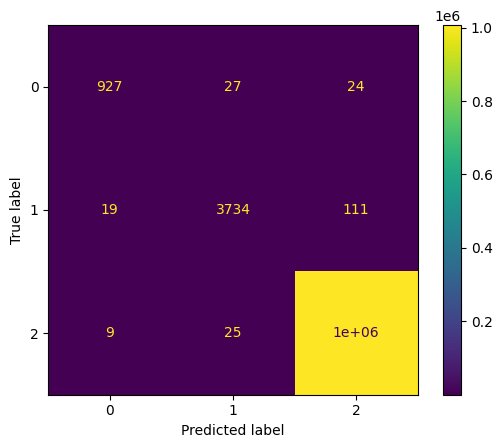

In [120]:
cm_rf = confusion_matrix(y_train, y_train_pred_rf)
disp = ConfusionMatrixDisplay(cm_rf)
disp.plot();

* Grupo de testeo

In [129]:
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.46      0.30      0.36       230
           1       0.75      0.47      0.57      1070
           2       1.00      1.00      1.00    216041

    accuracy                           1.00    217341
   macro avg       0.73      0.59      0.65    217341
weighted avg       1.00      1.00      1.00    217341



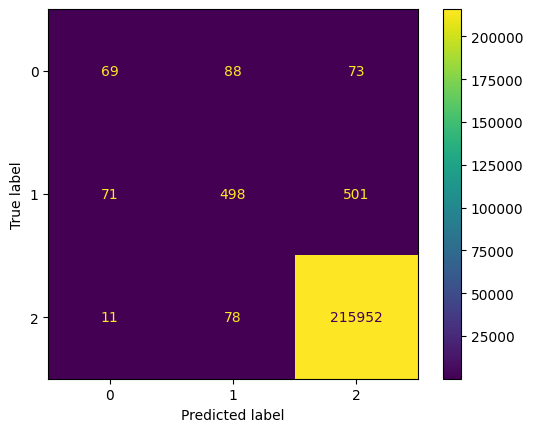

In [130]:
cm_rf_test = confusion_matrix(y_test, y_test_pred_rf)
disp = ConfusionMatrixDisplay(cm_rf_test)
disp.plot();

### Extreme Gradient Boosting

El modelo de Extreme Gradient Boosting es uno de los mejores en el caso de estudio de nacimientos y defunciones fetales [Application of machine learning in analysis of infant mortality and its factors, Singha, Aayush Kumar and Phukan]  [Neonatal mortality prediction with routinely collected data: a machine learning approach, Batista, André FM and Diniz]. Debido al tiempo que toma en ajustarse este modelo nada más hemos aplicado el modelo XGB con sus hiperparámetros por defecto, debemos afinar los hiperparámetros para tratar de obtener un mejor resultado.

* Grupo de entrenamiento

In [139]:
print(classification_report(y_train, y_train_pred_xgb))

              precision    recall  f1-score   support

           0       0.79      0.52      0.63       978
           1       0.82      0.59      0.69      3864
           2       1.00      1.00      1.00   1006629

    accuracy                           1.00   1011471
   macro avg       0.87      0.70      0.77   1011471
weighted avg       1.00      1.00      1.00   1011471



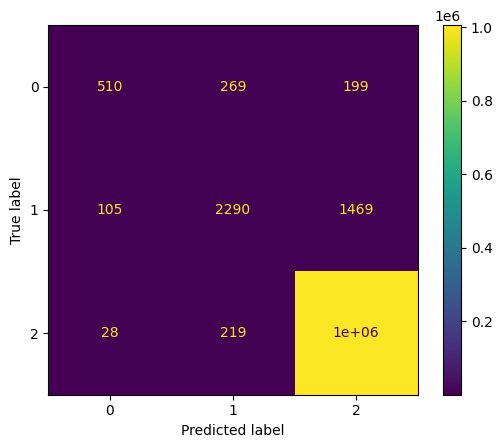

In [140]:
cm_xgb_train = confusion_matrix(y_train, y_train_pred_xgb)
disp = ConfusionMatrixDisplay(cm_xgb_train)
disp.plot();

* Grupo de testeo

In [141]:
print(classification_report(y_test, y_test_pred_xgb))

              precision    recall  f1-score   support

           0       0.49      0.36      0.42       230
           1       0.77      0.53      0.63      1070
           2       1.00      1.00      1.00    216041

    accuracy                           1.00    217341
   macro avg       0.75      0.63      0.68    217341
weighted avg       1.00      1.00      1.00    217341



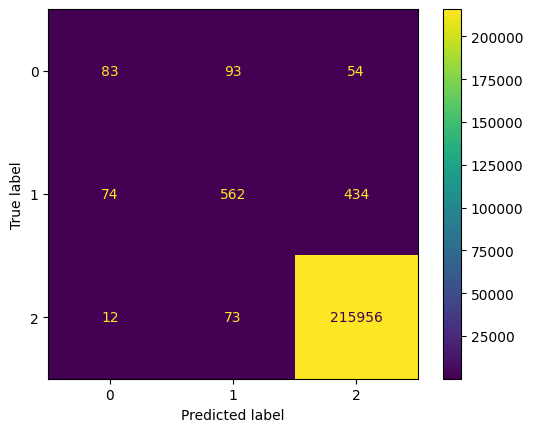

In [142]:
cm_xgb_test = confusion_matrix(y_test, y_test_pred_xgb)
disp = ConfusionMatrixDisplay(cm_xgb_test)
disp.plot();

### LightGBM

El modelo LightGBM es ideal para grupo de datos que tienen una gran dimensión, este fue el modelo más rápido en ejecutarse. Sin embargo sus métrica indica una precisión, exhaustividad y f1-score muy bajas.

* Grupo de entrenamiento

In [133]:
print(classification_report(y_train, y_train_pred_lgbm))

              precision    recall  f1-score   support

           0       0.52      0.44      0.48       978
           1       0.72      0.54      0.61      3864
           2       1.00      1.00      1.00   1006629

    accuracy                           1.00   1011471
   macro avg       0.75      0.66      0.70   1011471
weighted avg       1.00      1.00      1.00   1011471



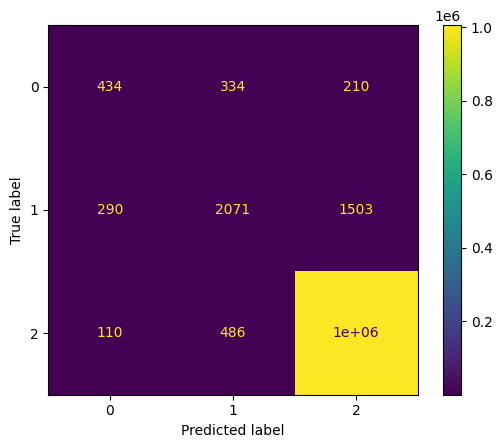

In [134]:
cm_lgbm_train = confusion_matrix(y_train, y_train_pred_lgbm)
disp = ConfusionMatrixDisplay(cm_lgbm_train)
disp.plot();

* Grupo de testeo

In [135]:
print(classification_report(y_test, y_test_pred_lgbm))

              precision    recall  f1-score   support

           0       0.32      0.37      0.34       230
           1       0.69      0.48      0.56      1070
           2       1.00      1.00      1.00    216041

    accuracy                           1.00    217341
   macro avg       0.67      0.61      0.64    217341
weighted avg       1.00      1.00      1.00    217341



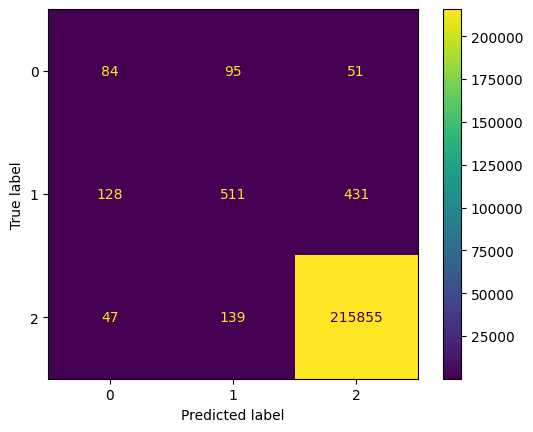

In [136]:
cm_lgbm_test = confusion_matrix(y_test, y_test_pred_lgbm)
disp = ConfusionMatrixDisplay(cm_lgbm_test)
disp.plot();

## Elije tu modelo de “producción” y justifica esta decisión

* El mejor modelo que encontramos es el XGBoosting por las siguientes razones:
1. A pesar de el tiempo que tomó en la ejecución el resultado de su exactitud fué el mejor.
2. La métrica de exactitud, exhaustividad y f1-score son las más altas.
3. En el problema, lo que nos interesa es identificar el número de estados 0 y 1, que representan a nacidos muertos y abortos. El modelo elegido justamente, es el que mejor predice estos grupos. A continuación se puede observar algunos resultados de las métricas que se compararon para su elección.

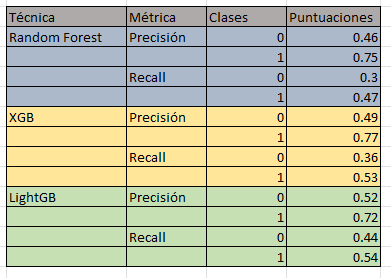